# CS446/546 - Class Session 6 - Degree Distribution

In this class session we are going to plot the degree distribution of the undirected human
protein-protein interaction network (PPI), without using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder) and we'll 
manually compute the degree of each vertex (protein) in the network. We'll then compute
the count `N(k)` of vertices that have a given vertex degree `k`, for all `k` values.
Finally, we'll plot the degree distribution and discuss whether it is consistent with the 
results obtained in the Jeong et al. article for the yeast PPI.  

We'll start by loading all of the Python modules that we will need for this notebook.  Because we'll be calling a bunch of functions from `numpy` and `matplotlib.pyplot`, we'll alias them as `np` and `plt`, respectively.

In [59]:
import pandas
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import igraph

Step 1:  load in the SIF file as a `pandas` data frame using `pandas.read_csv`.  Make sure the column names of your data frame are `species1`, `interaction_type`, and `species2`. Save the data frame as the object `sif_data`.

In [60]:
sif_data = pandas.read_csv("shared/pathway_commons.sif",
                            sep="\t", names=["species1","interaction_type","species2"])

Step 2:  restrict the interactions to protein-protein undirected ("in-complex-with", "interacts-with"). The restricted data frame should be called `interac_ppi`. Then we will make a copy using `copy` so `interac_ppi` is independent of `sif_data` which will be convenient for this exercise.

In [63]:
interaction_types_ppi = set(["interacts-with",
                             "in-complex-with"])
interac_ppi = sif_data[sif_data.interaction_type.isin(interaction_types_ppi)].copy()

Step 3: for each interaction, reorder `species1` and `species2` (if necessary) so that
`species1 < species2` (in terms of the species names, in lexicographic order).  You can make a boolean vector `boolean_vec` containing (for each row of the data frame `interac_ppi`) `True` if `species2 > species1` (by lexicographic order) for that row, or `False` otherwise.  You can then use the `loc` method on the data frame, to select rows based on `boolean_vec` and the two columns that you want (`species1` and `species2`). Thanks to Garrett Bauer for suggesting this approach (which is more elegant than looping over all rows):

In [67]:
boolean_vec = interac_ppi['species1'] > interac_ppi['species2']
interac_ppi.loc[boolean_vec, ['species1', 'species2']] = interac_ppi.loc[boolean_vec, ['species2', 'species1']].values

Since iterating is reasonably fast in Python, you could also do this using a `for` loop through all of the rows of the data frame, swapping `species1` and `species2` entries as needed (and in-place in the data frame) so that in the resulting data frame `interac_ppi` satisfies `species1 < species2` for all rows.

In [40]:
for i in range(0, interac_ppi.shape[0]):
    if interac_ppi.iat[i,0] > interac_ppi.iat[i,2]:
        temp_name = interac_ppi.iat[i,0]
        interac_ppi.set_value(i, 'species1', interac_ppi.iat[i,2])
        interac_ppi.set_value(i, 'species2', temp_name)

Step 4: Restrict the data frame to only the columns `species1` and `species2`. Use the `drop_duplicates` method to subset the rows of the resulting two-column data frame to only unique rows. Assign the resulting data frame object to have the name `interac_ppi_unique`.  This is basically selecting only unique pairs of proteins, regardless of interaction type.

In [41]:
interac_ppi_unique = interac_ppi[["species1","species2"]].drop_duplicates()

Step 5: compute the degree of each vertex (though we will not associate the vertex degrees with vertex names here, since for this exercise we only need the vector of vertex degree values, not the associated vertex IDs).  You'll want to create an object called `vertex_degrees_ctr` which is of class `collections.Counter`.  You'll want to name the final list of vertex degrees, `vertex_degrees`.

In [42]:
vertex_degrees_ctr = collections.Counter()
allproteins = interac_ppi_unique["species1"].tolist() + interac_ppi_unique["species2"].tolist()
for proteinname in allproteins:
    vertex_degrees_ctr.update([proteinname])
vertex_degrees = list(vertex_degrees_ctr.values())

Let's print out the vertex degrees of the first 10 vertices, in whatever the key order is. Pythonistas -- anyone know of a less convoluted way to do this?

In [43]:
dict(list(dict(vertex_degrees_ctr).items())[0:9])

{'CASP3': 189,
 'DHX15': 398,
 'GOLGA2': 551,
 'JUNB': 87,
 'NHSL2': 18,
 'OR52D1': 3,
 'PRDM15': 12,
 'PTS': 24,
 'ZNF738': 1}

Let's print out the first ten entries of the `vertex_degrees` list.  Note that we don't expect it to be in the same order as the output from the previous command above, since `dict` changes the order in the above.

In [44]:
vertex_degrees[0:9]

[398, 396, 9, 12, 19, 2, 18, 1, 24]

Step 6: Calculate the histogram of N(k) vs. k, using 30 bins, using `plt.hist`.  You'll probably want to start by making a `numpy.array` from your `vertex_degrees`.  Call the resulting object from `plt.hist`, `hist_res`. Obtain a numpy array of the bin counts as element zero from `hist_res` (name this object `hist_counts`) and obtain a numpy array of the bin centers (which are `k` values) as element one from `hist_res` (name this object `hist_breaks`). Finally, you want the `k` values of the centers of the bins, not the breakpoint values. So you'll have to do some arithmetic to go from the 31 `k` values of the bin breakpoints, to a numpy array of the 30 `k` values of the centers of the bins.  You should call that object `kvals`.

In [45]:
nbins=30
hist_res = plt.hist(np.array(vertex_degrees), bins=nbins)
hist_counts = hist_res[0]
hist_breaks = hist_res[1]
kvals = 0.5*(hist_breaks[0:(nbins-1)]+hist_breaks[1:nbins])

Let's print the k values of the bin centers:

In [46]:
kvals

array([   39.48333333,   116.45      ,   193.41666667,   270.38333333,
         347.35      ,   424.31666667,   501.28333333,   578.25      ,
         655.21666667,   732.18333333,   809.15      ,   886.11666667,
         963.08333333,  1040.05      ,  1117.01666667,  1193.98333333,
        1270.95      ,  1347.91666667,  1424.88333333,  1501.85      ,
        1578.81666667,  1655.78333333,  1732.75      ,  1809.71666667,
        1886.68333333,  1963.65      ,  2040.61666667,  2117.58333333,
        2194.55      ])

Let's print the histogram bin counts:

In [47]:
hist_counts

array([  1.39750000e+04,   2.05800000e+03,   7.02000000e+02,
         3.63000000e+02,   1.80000000e+02,   1.02000000e+02,
         4.50000000e+01,   5.90000000e+01,   1.30000000e+01,
         8.00000000e+00,   8.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   5.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00])

Step 7: Plot `N(k)` vs. `k`, on log-log scale (using only the first 14 points, which is plenty sufficient to see the approximatey scale-free degree distribution and where it becomes exponentially suppressed at high `k`.  For this you'll use `plt.loglog`.  You'll probably want to adjust the x-axis limits using `plt.gca().set_xlim()`.  To see the plot, you'll have to do `plt.show()`.

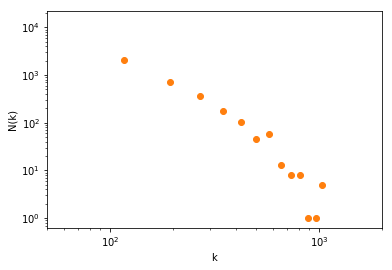

In [48]:
plt.loglog(kvals[1:14],
           hist_counts[1:14], "o")
plt.xlabel("k")
plt.ylabel("N(k)")
plt.gca().set_xlim([50, 2000])
plt.show()

Step 8:  Do a linear fit to the log10(N(k)) vs. log10(k) data (just over the range in which the relationship appears to be linear, which is the first four points).  You'll want to use `scipy.stats.linregress` to do the linear regression.  Don't forget to log10-transform the data using `np.log10`.

In [49]:
scipy.stats.linregress(np.log10(kvals[0:3]), np.log10(hist_counts[0:3]))

LinregressResult(slope=-1.8649113848633849, intercept=7.1331933823474394, rvalue=-0.99899003626857941, pvalue=0.028614395034211836, stderr=0.083879386892290159)

Slope is -1.87 with SE 0.084, i.e., gamma = 1.87 with a 95% CI of about +/- 0.17.

Now let's compute the slope for the degree distribution Fig. 1b in the Jeong et al. article, for the yeast PPI.  The change in ordinate over the linear range is about -6.5 in units of natural logarithm. The change in abscissa over the linear range is approximately log(45)-log(2), so we can compute the Jeong et al. slope thus:

In [50]:
jeong_slope = -6.5/(np.log(45)-np.log(2))
print("%.2f" % jeong_slope)

-2.09


How close was your slope from the human PPI, to the slope for the yeast PPI from the Jeong et al. article?

Now we'll do the same thing in just a few lines of igraph code

In [58]:
g = igraph.Graph.TupleList(interac_ppi_unique.values.tolist(), directed=False)

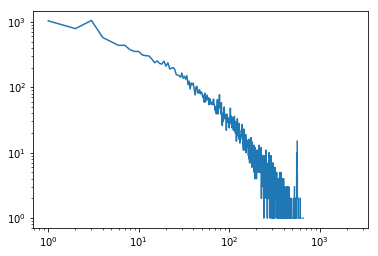

In [52]:
xs, ys = zip(*[(left, count) for left, _, count in 
         g.degree_distribution().bins()])
plt.loglog(xs, ys)
plt.show()

In [53]:
igraph.statistics.power_law_fit(g.degree())

FittedPowerLaw(continuous=False, alpha=3.481758064522252, xmin=245.0, L=-4321.08945321598, D=0.04983048306638982, p=0.0557169127937001)